In [52]:
import torch
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler
from disen_net import Image_adapter
import os
import open_clip
from PIL import Image

model_id = "stabilityai/stable-diffusion-2-1-base"
pipe = StableDiffusionPipeline.from_pretrained(model_id).to("cuda")
with torch.no_grad():
    img_model, _, preprocess = open_clip.create_model_and_transforms('ViT-H-14', pretrained='laion2b_s32b_b79k')
    img_model = img_model.to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [16]:
lora_path = "./output/checkpoint-1200"
pipe.load_lora_weights(lora_path)
adapter = Image_adapter().to("cuda")
info = torch.load(os.path.join(lora_path, "adapter.pt"))
adapter.load_state_dict(info)

<All keys matched successfully>

In [3]:
def disenbooth_infer(pipe, img_model, adapter=None, prompt = None, reference_image=None ,text_weight=1.0, image_weight=0.0, 
                    height = 512, width = 512, num_inference_steps = 50, guidance_scale= 7.0, negative_prompt = None, 
                    num_images_per_prompt = 1, eta = 0.0, generator = None, latents = None, prompt_embeds = None, 
                    negative_prompt_embeds = None, output_type = "pil", return_dict = True, cross_attention_kwargs = None, 
                    guidance_rescale: float = 0.0, clip_skip=None):
    with torch.no_grad():
        height = height or pipe.unet.config.sample_size * pipe.vae_scale_factor
        width = width or pipe.unet.config.sample_size * pipe.vae_scale_factor
        # to deal with lora scaling and other possible forward hooks
    
        # 1. Check inputs. Raise error if not correct
    
        pipe._guidance_scale = guidance_scale
        pipe._guidance_rescale = guidance_rescale
        pipe._cross_attention_kwargs = cross_attention_kwargs
        pipe._clip_skip = clip_skip

        img_feature = img_model.encode_image( reference_image ).unsqueeze(1) 
        if adapter is not None:
            img_feature = adapter(img_feature)
    
        # 2. Define call parameters
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]
    
        device = pipe._execution_device
        lora_scale = (pipe.cross_attention_kwargs.get("scale", None) if pipe.cross_attention_kwargs is not None else None)
    
        prompt_embeds, negative_prompt_embeds = pipe.encode_prompt(
            prompt,
            device,
            num_images_per_prompt,
            pipe.do_classifier_free_guidance,
            negative_prompt,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            lora_scale=lora_scale,
            clip_skip=pipe.clip_skip,
        )
        if pipe.do_classifier_free_guidance:
            prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])
            img_feature = torch.cat([torch.zeros_like(img_feature),img_feature])
        prompt_embeds = text_weight*prompt_embeds + image_weight*img_feature
        
        # 4. Prepare timesteps
        pipe.scheduler.set_timesteps(num_inference_steps, device=device)
        timesteps = pipe.scheduler.timesteps
    
        # 5. Prepare latent variables
        num_channels_latents = pipe.unet.config.in_channels
        latents = pipe.prepare_latents(
            batch_size * num_images_per_prompt,
            num_channels_latents,
            height,
            width,
            prompt_embeds.dtype,
            device,
            generator,
            latents,
        )
    
        # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = pipe.prepare_extra_step_kwargs(generator, eta)
    
        # 6.5 Optionally get Guidance Scale Embedding
        timestep_cond = None
        if pipe.unet.config.time_cond_proj_dim is not None:
            guidance_scale_tensor = torch.tensor(pipe.guidance_scale - 1).repeat(batch_size * num_images_per_prompt)
            timestep_cond = pipe.get_guidance_scale_embedding(
                guidance_scale_tensor, embedding_dim=pipe.unet.config.time_cond_proj_dim
            ).to(device=device, dtype=latents.dtype)
    
        # 7. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * pipe.scheduler.order
        pipe._num_timesteps = len(timesteps)
        with pipe.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if pipe.do_classifier_free_guidance else latents
                latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)
    
                # predict the noise residual
                noise_pred = pipe.unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=prompt_embeds,
                    timestep_cond=timestep_cond,
                    cross_attention_kwargs=pipe.cross_attention_kwargs,
                    return_dict=False,
                )[0]
    
                # perform guidance
                if pipe.do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + pipe.guidance_scale * (noise_pred_text - noise_pred_uncond)
    
                if pipe.do_classifier_free_guidance and pipe.guidance_rescale > 0.0:
                    # Based on 3.4. in https://arxiv.org/pdf/2305.08891.pdf
                    noise_pred = rescale_noise_cfg(noise_pred, noise_pred_text, guidance_rescale=pipe.guidance_rescale)
                # compute the previous noisy sample x_t -> x_t-1
                latents = pipe.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % pipe.scheduler.order == 0):
                    progress_bar.update()
        image = pipe.vae.decode(latents / pipe.vae.config.scaling_factor, return_dict=False, generator=generator)[0]
        if torch.is_tensor(image):
            feature_extractor_input = pipe.image_processor.postprocess(image, output_type="pil")
        else:
            feature_extractor_input = pipe.image_processor.numpy_to_pil(image)
        image = feature_extractor_input
    return image

## Subject-driven text-to-image generation

  0%|          | 0/50 [00:00<?, ?it/s]

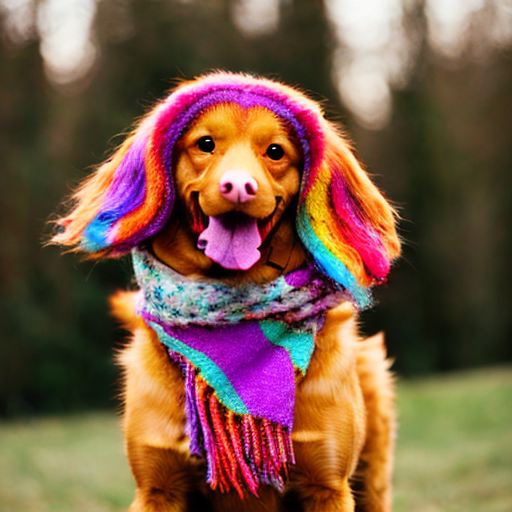

In [30]:
torch.manual_seed(1)
ref_im = Image.open("./dog7/00.jpg")
ref_image = preprocess(ref_im).unsqueeze(0).to("cuda")
image = disenbooth_infer(pipe, img_model, adapter, reference_image=ref_image, prompt = "a dog</w> dog wearing a colorful scarf", text_weight=1.0, image_weight=0.0)[0]
image

## Identity-irrelevant generation

  0%|          | 0/50 [00:00<?, ?it/s]

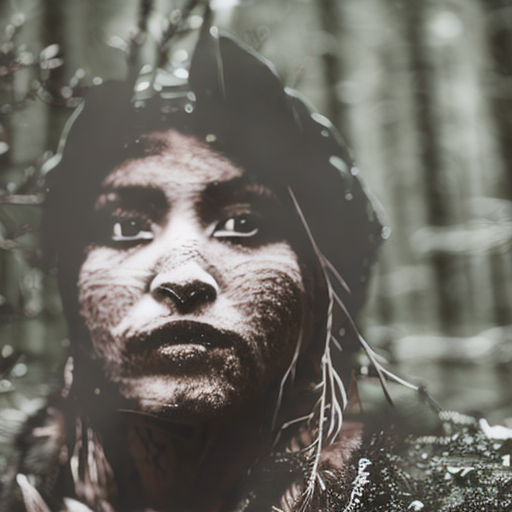

In [38]:
ref_im = Image.open("./dog7/00.jpg")
ref_image = preprocess(ref_im).unsqueeze(0).to("cuda")
image = disenbooth_infer(pipe, img_model, adapter, reference_image=ref_image, prompt = "", text_weight=0.0, image_weight=1.0)[0]
image

## Customization with identity-irrelevant information
generating different subjects, the image weight and text weight need to be adjusted

  0%|          | 0/50 [00:00<?, ?it/s]

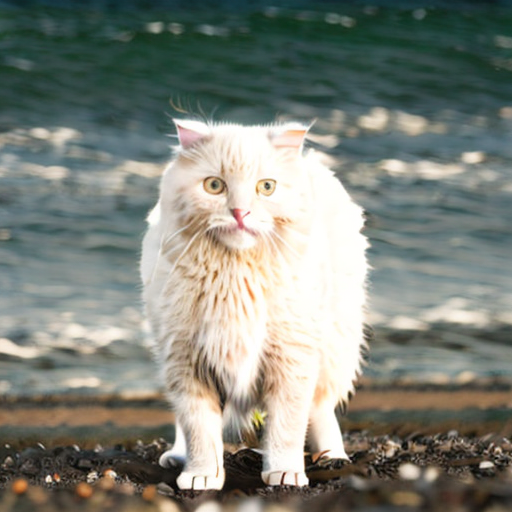

In [51]:
ref_im = Image.open("./dog7/02.jpg")
ref_image = preprocess(ref_im).unsqueeze(0).to("cuda")
image = disenbooth_infer(pipe, img_model, adapter, reference_image=ref_image, prompt = "a white cat", text_weight=1.0, image_weight=1.0)[0]
image